# Mask R-CNN (VEGA-cropped)

---
## Importovanie modulov:

In [1]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
import skimage

---
## Importovanie Mask R-CNN modulov:

In [2]:
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

2022-05-18 22:06:26.837110: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


---
## Nastavenie počiatočných ciest (logy, pred-trénovaný model):

In [3]:
# Nastavenie koreňového priečinka implementácie MASK R-CNN
ROOT_DIR = "mask_rcnn_aktwelve"
# Import MASK R-CNN knižníc
sys.path.append(ROOT_DIR)
# Vytvorenie priečinka na uloženie logov a výsledného natrénovaného modelu MASK R-CNN
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Cesta k pred-trénovanému referenčnému modelu
COCO_MODEL_FILE = "mask_rcnn_coco.h5"
# Stiahnutie pred-trénovaného referenčného modelu, ak neexistuje
if not os.path.exists(COCO_MODEL_FILE):
    utils.download_trained_weights(COCO_MODEL_FILE)

---
## Trénovanie - konfigurácia modelu:

In [4]:
class DigitsConfig(Config):
 
    NAME = "HandwrittenDigitsVega"
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4
    
    NUM_CLASSES = 10 + 1  # 10 číslic + pozadie
    STEPS_PER_EPOCH = 1660
    VALIDATION_STEPS = 50
    LEARNING_RATE = 0.001
    LEARNING_MOMENTUM = 0.9
    
    BACKBONE = "resnet50"
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    POST_NMS_ROIS_INFERENCE = 500
    POST_NMS_ROIS_TRAINING = 1000

    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128
    IMAGE_CHANNEL_COUNT = 3

    
config = DigitsConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                23
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

---
## Definícia COCO formátu:

In [5]:
class CocoLikeDataset(utils.Dataset):
    
    # Načítanie dát (obrázkov) a anotácii
    def load_data(self, annotation_json, images_dir):
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Pridanie mien jednotlivých tried
        source_name = "coco_like"
        for category in coco_json["categories"]:
            class_id = category["id"]
            class_name = category["name"]
            if class_id < 1:
                print(f"Error: Class id for {class_name} cannot be less than one. (0 is reserved for the background)")
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Získanie všetkých anotácii
        annotations = {}
        for annotation in coco_json["annotations"]:
            image_id = annotation["image_id"]
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Získanie všetkých dát (obrázkov)
        seen_images = {}
        for image in coco_json["images"]:
            image_id = image["id"]
            if image_id in seen_images:
                print(f"Warning: Skipping duplicate image id: {image}")
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image["file_name"]
                    image_width = image["width"]
                    image_height = image["height"]
                except KeyError as key:
                    print(f"Warning: Skipping image (id: {image_id}) with missing key: {key}")
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Pridanie obrázka
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
    
    # Načítanie masiek z anotácii
    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        annotations = image_info["annotations"]
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation["category_id"]
            mask = Image.new("1", (image_info["width"], image_info["height"]))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation["segmentation"]:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

---
## Načítanie datasetov (trénovanie/validácia):

In [6]:
dataset_train = CocoLikeDataset()
dataset_train.load_data("./datasets/vega/train/annotations-cropped.json", "./datasets/vega/train/cropped")
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data("./datasets/vega/val/annotations-cropped.json", "./datasets/vega/val/cropped")
dataset_val.prepare()

---
## Vizualizácia vzoriek dát (číslic):

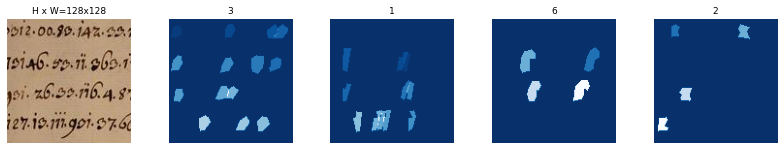

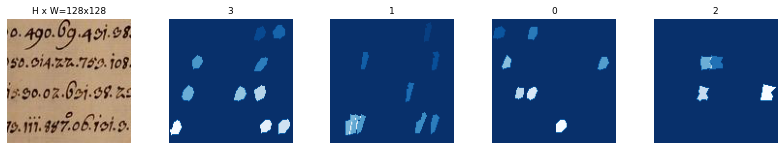

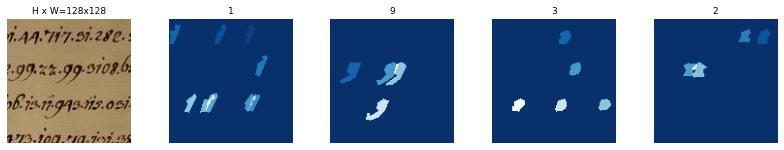

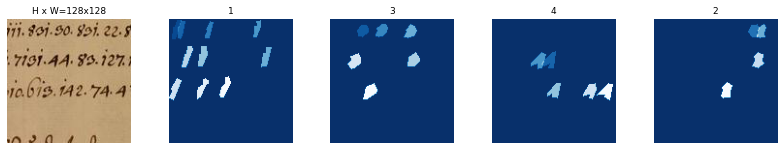

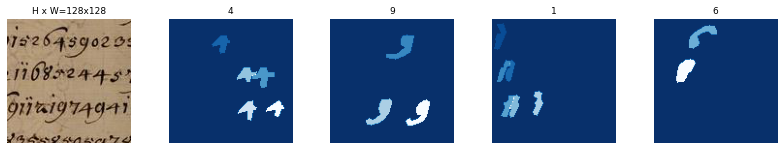

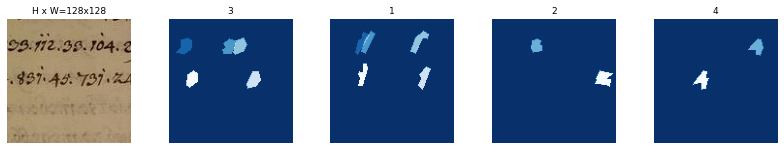

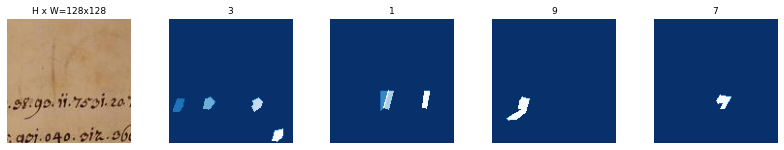

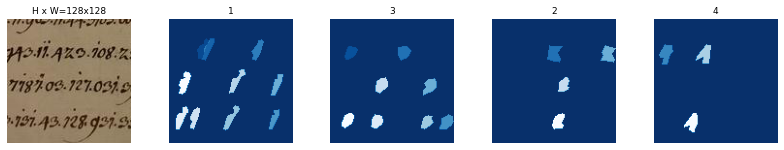

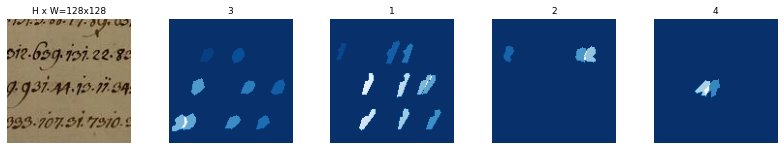

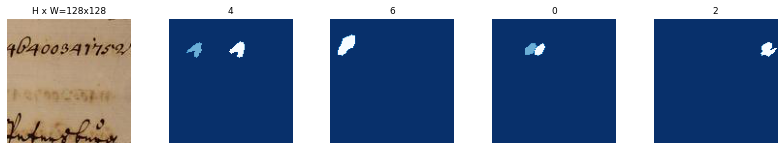

In [7]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 10) 
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id) 
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

---
## Trénovanie - vytvorenie modelu:

In [ ]:
# Vytvorenie modelu v tréningovom móde
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

In [ ]:
# Inicializácia počiatočných váh
init_with = "coco"  # "imagenet", "coco", alebo "last"

#Načítaie váh typu "imagenet" 
if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
#Načítaie váh typu "coco" 
elif init_with == "coco":
    model.load_weights(COCO_MODEL_FILE, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
#Načítaie posledných natrénovaných váh
elif init_with == "last":
    model.load_weights(model.find_last(), by_name=True)

---
## Trenovanie - spustenie trénovania modelu:

In [ ]:
# Trénovaie "heads" predtrénovanej COCO siete
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=100,
            layers="heads")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f"Training took {minutes} minutes")

---
## Inferencia - konfigurácia modelu:

In [13]:
class InferenceDigitsConfig(DigitsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.6
    
inference_config = InferenceDigitsConfig()
inference_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.6
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                23
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

---
## Inferencia - vytvorenie modelu:

In [14]:
inference_model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

In [15]:
# Načítanie natrénovanej siete, respektíve jej váh v .h5 súbore
model_path = "./mask_rcnn_aktwelve/logs/handwrittendigitsvega20220517T2325/mask_rcnn_handwrittendigitsvega_0100.h5"

assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
inference_model.load_weights(model_path, by_name=True)

Loading weights from  ./mask_rcnn_aktwelve/logs/handwrittendigitsvega20220517T2325/mask_rcnn_handwrittendigitsvega_0100.h5
Re-starting from epoch 100


---
## Inferencia - spustenie inferencie na VEGA:

Processing 1 images
image                    shape: (1024, 640, 3)        min:    0.00000  max:  217.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:   83.30000  float64
image_metas              shape: (1, 23)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
5
5


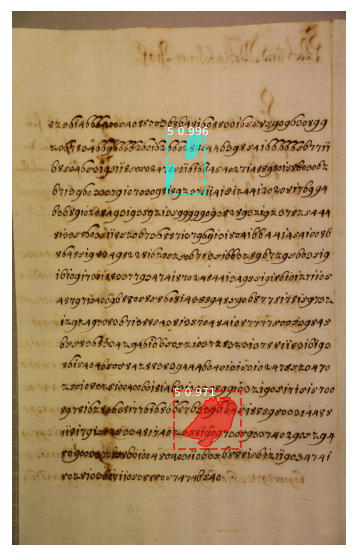

Processing 1 images
image                    shape: (1024, 640, 3)        min:    0.00000  max:  214.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:   70.30000  float64
image_metas              shape: (1, 23)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
5


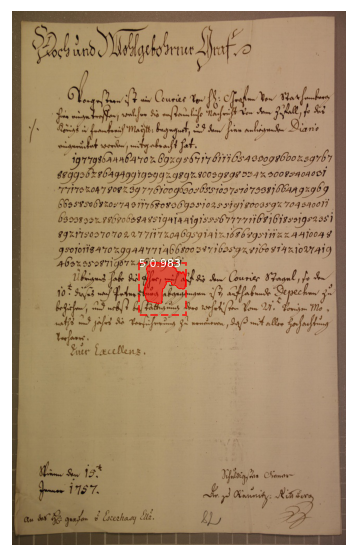

Processing 1 images
image                    shape: (1024, 640, 3)        min:    0.00000  max:  205.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:   65.30000  float64
image_metas              shape: (1, 23)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
0


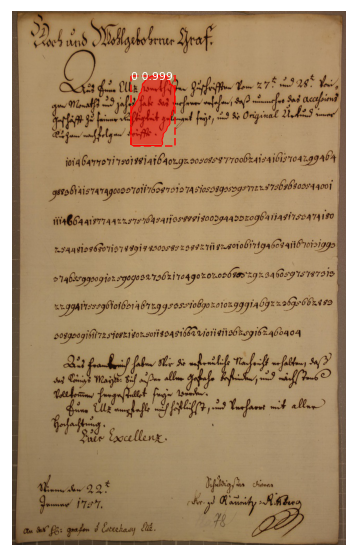

In [17]:
real_test_dir = "./datasets/vega/test/JPEGImages/"
image_paths = []
class_names = ['BG', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
i = 0 

for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in [".png", ".jpg", ".jpeg"]:
        image_paths.append(os.path.join(real_test_dir, filename))
    i += 1
    if i == 5:
        break

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = inference_model.detect([img_arr], verbose=1)
    r = results[0]
    for cls_id in r["class_ids"]:
        print(class_names[int(cls_id)])
    visualize.display_instances(img, r["rois"], r["masks"], r["class_ids"], 
                                class_names, r["scores"], figsize=(10, 10))

---
## Inferencia - spustenie inferencie na VEGA cropped:

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  218.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -116.80000  max:   94.30000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
3
3
9
1
7
7
1
5
0
7
1
2
8
7
3
8
4
7
8
2
8
7
0
7
1
0
3
5
0
5
1


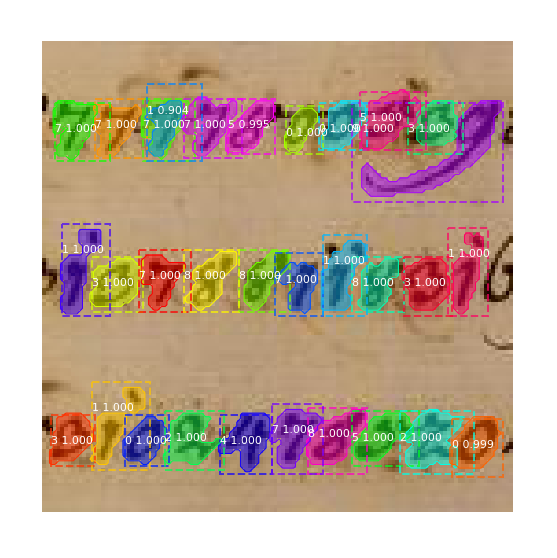

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  205.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -116.80000  max:   81.30000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
6
4
2
2
1
7
4
5
0
1
4
1
5
7
3
0
9
4


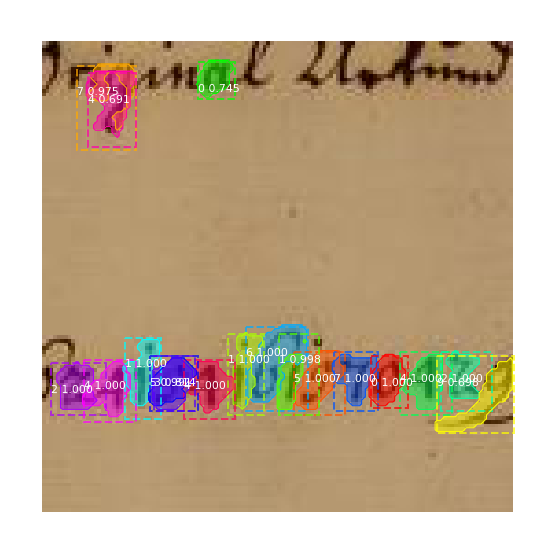

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  221.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -116.80000  max:   97.30000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
1
1
6
3
9
1
4
7
9
7
9
4
6
5
1
7
4
0
8
1
8
2
0
2
0
8
2
1
4
8
3
3


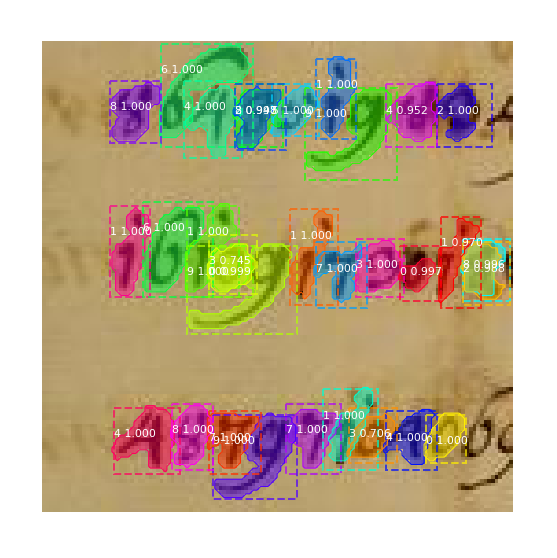

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  207.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -116.80000  max:   83.30000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
8
4
1
8
6
7
1
0
4
1
2
0
5
1
0
3
7
4
2


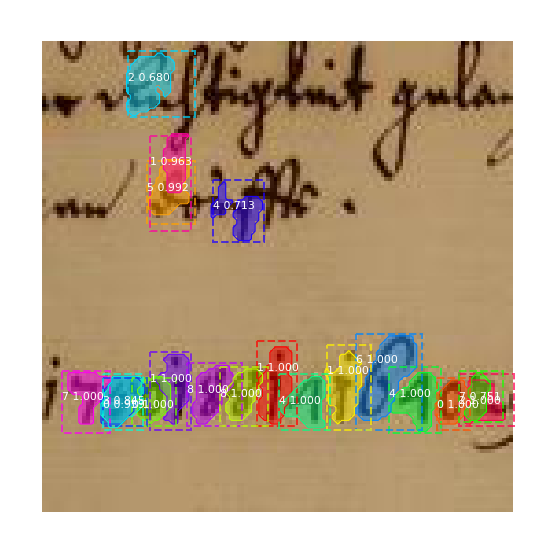

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  211.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -116.80000  max:   87.30000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
1
4
3
6
3
1
8
3
7
9
3
9
9
6
5
9
0
0
4
8
3
5
6
1
7
0
1
1
0


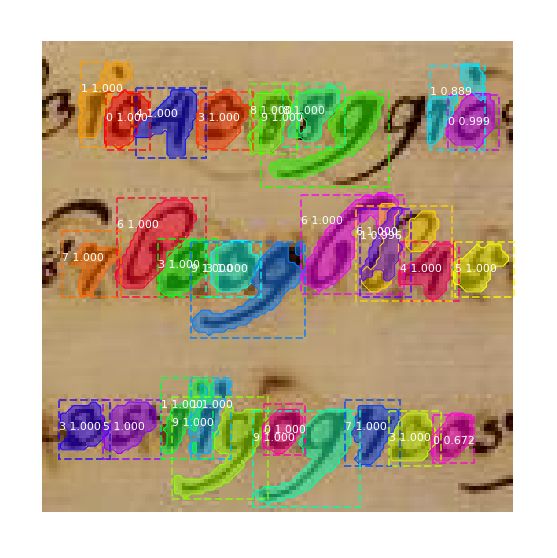

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  210.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -116.80000  max:   86.30000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
6
5
3
4
7
4
4
7
3
6
8
6
8
9
0
1
3
2
8
1
0
8
7
5
8


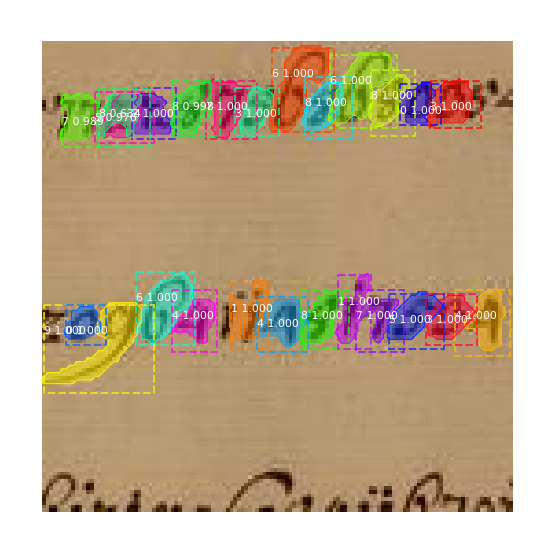

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  218.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -116.80000  max:   94.30000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
6
4
6
1
7
3
2
3
9
2
7
3
1
8
9
9
7
6
0
5
2
0
0
3
8
8
5
3
8
3
8
5
9
1
3
2


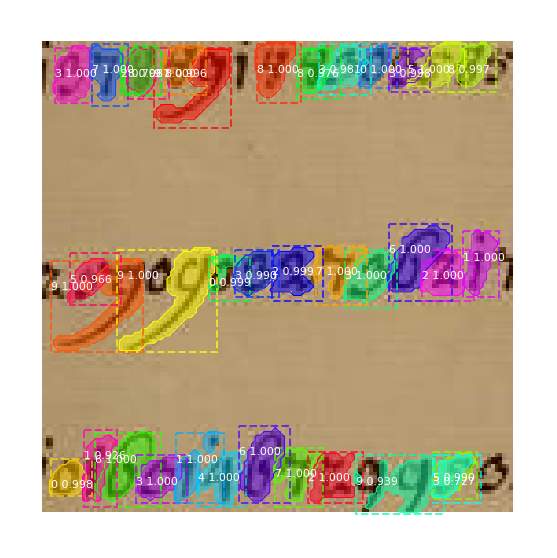

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  205.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -116.80000  max:   81.30000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
8
7
7
0
0
0
7
2
4
5
8
3
9
3
8


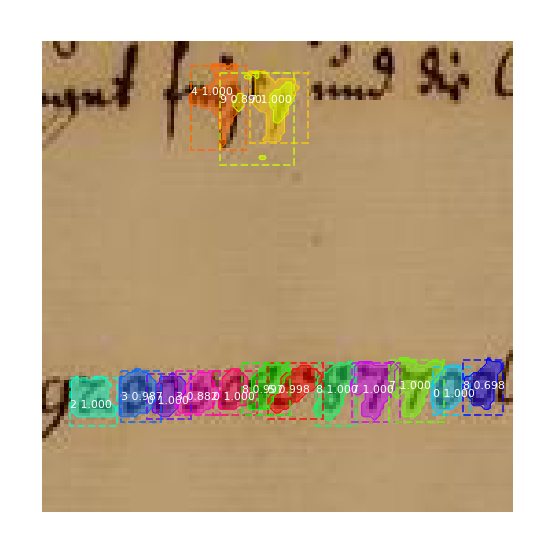

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  221.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -116.80000  max:   97.30000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
0
1
4
9
6
4
1
8
6
9
6
9
1
8
5
5
3
6
8
0
3
8
6
8
0
8
8
5
0
5
5
6
7
8
6
4
0


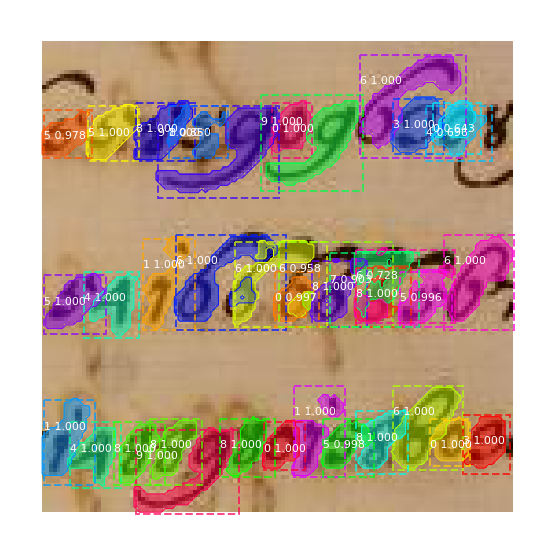

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  227.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -116.80000  max:  103.30000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
5
3
7
3
0
8
0
6
0
8
9
1
8
8
6
5
0
5
5
1
6
5


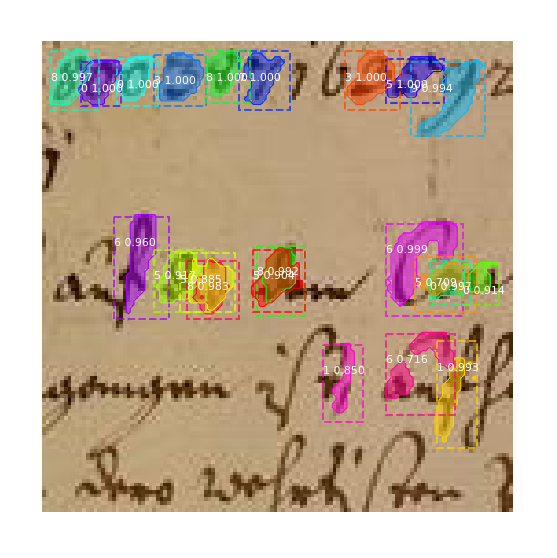

Processing 1 images
image                    shape: (128, 128, 3)         min:   95.00000  max:  200.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min:   -8.90000  max:   76.30000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32

*** No instances to display *** 



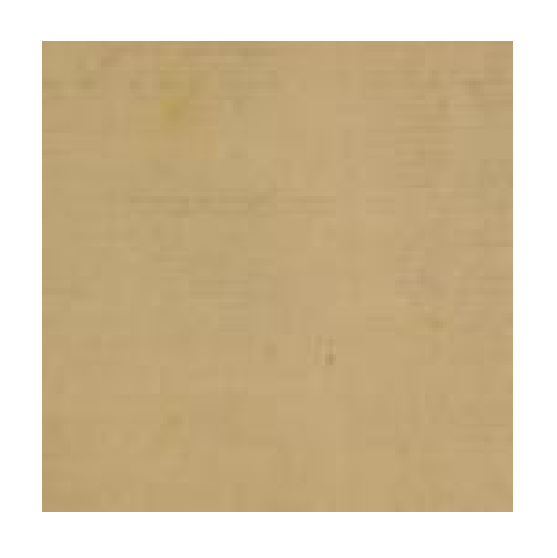

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  221.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -116.80000  max:   97.30000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
1
4
6
1
0
5
1
1
1
9
4
7
0
6
8
1
2
3
9
7
5
5
7
7
1
2
3
0
3
5
9
1
1
2
3
3
6
3
5
6
7
5
9
0
8
9
3
5
2
1
5


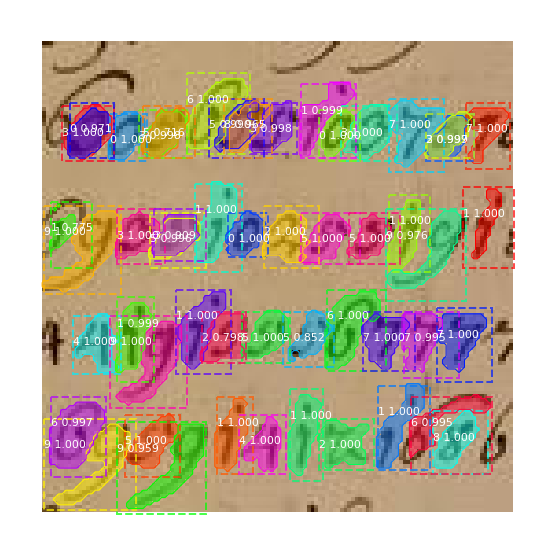

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  213.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -116.80000  max:   89.30000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
3
8
8
3
6
9
3
3
1
8
0
6
9
1
6
0
6
3
3
3
6
7
3
2
8
4
5
1
0
5
4


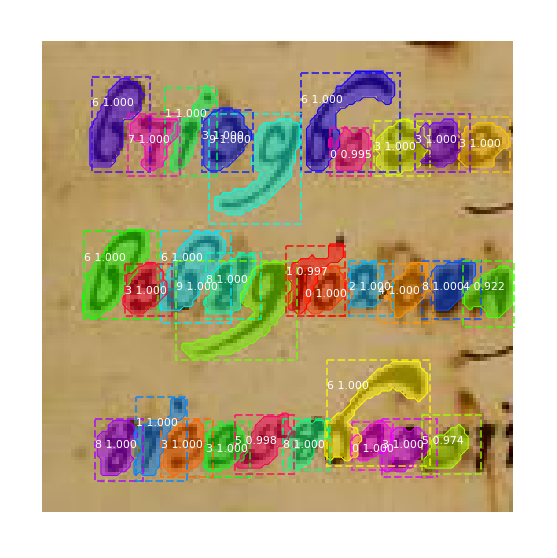

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  220.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -116.80000  max:   96.30000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
6
2
0
3
8
9
3
9
0
3
0
6
0
3
4
3
1
7
6
1


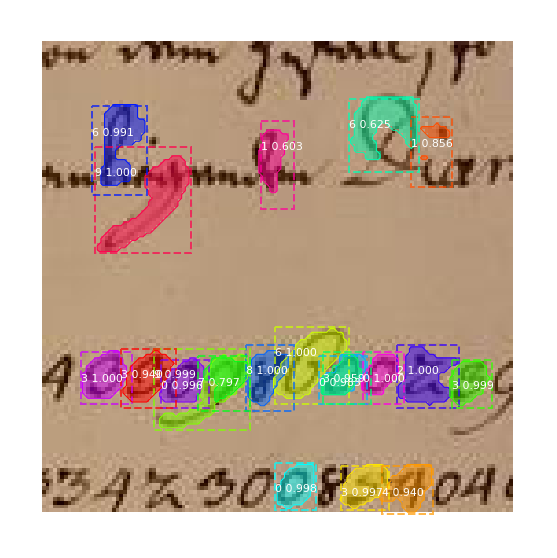

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  220.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -116.80000  max:   96.30000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
0
3
1
6
0
2
0
0
6
9
2
3
2
2
0
1
0
3
0
4
0
3
8
8
8
0
2
2


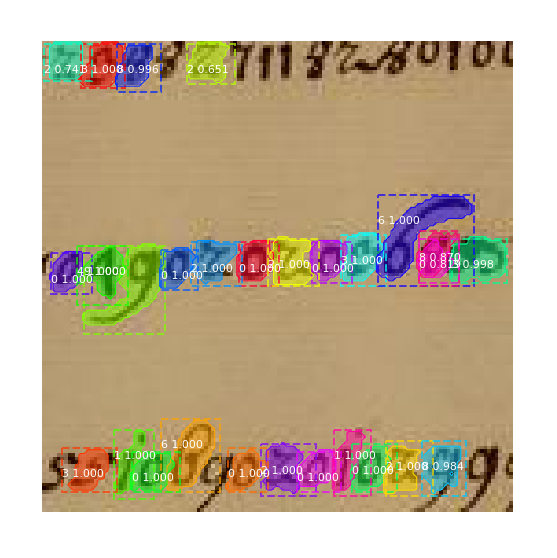

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  220.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -116.80000  max:   96.30000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
6
6
4
2
0
2
7
4
9
4
9
1
1
1
1
7
1
5
3
7
4
0


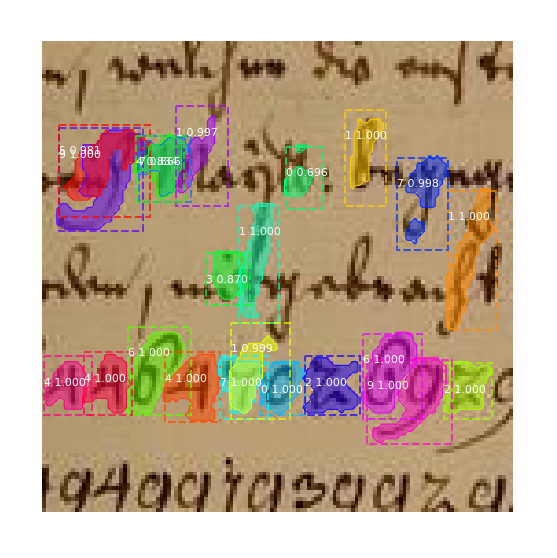

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  215.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -116.80000  max:   91.30000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
4
4
6
4
6
0
2
1
1
0
8
3
3


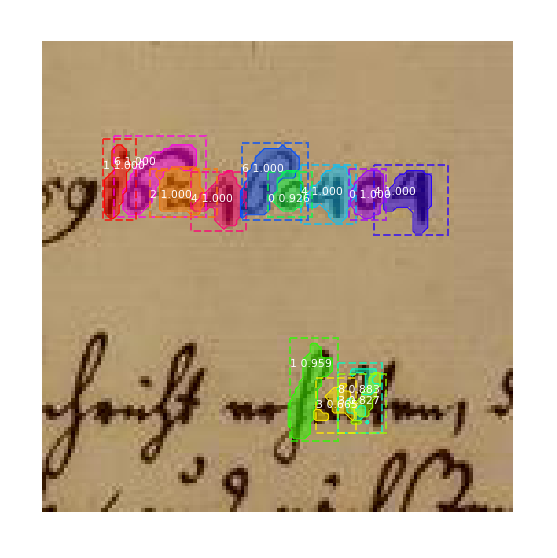

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  195.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -116.80000  max:   71.30000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
6
8
7
6
3
4
7
4
4
4
1
1
4
1
9
5
0
4
8
3
1
7
4
6
8
9
1
7


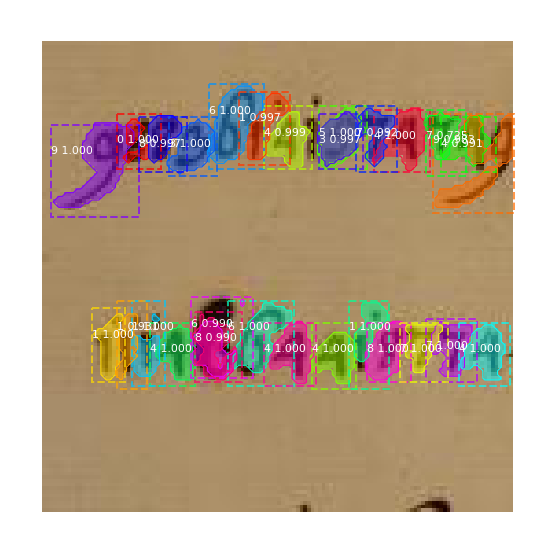

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  188.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -116.80000  max:   64.30000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
3
3
1
8
2
8
9
0
0
0
7
6
0
1
2
1
3


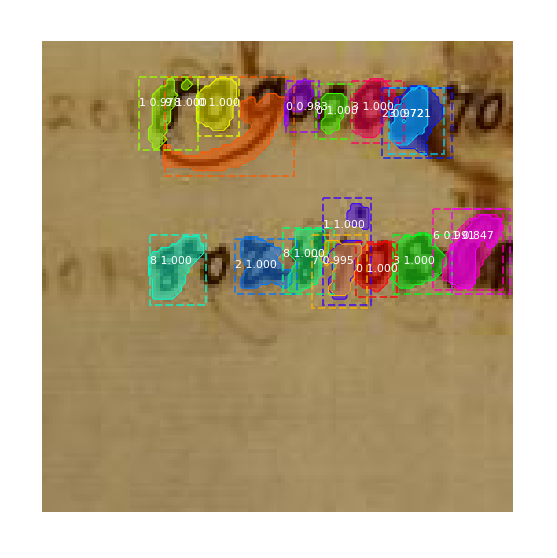

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  216.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -116.80000  max:   92.30000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
4
9
3
3
3
0
0
1
9
4
1
9
8
4
8
8
3
5
3
3
8
3
3
5
0
7
5
0


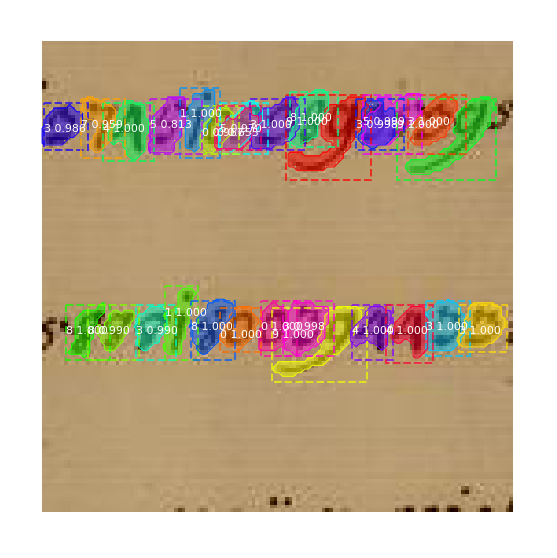

In [18]:
real_test_dir = "./datasets/vega/test/cropped/"
image_paths = []
class_names = ['BG', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
i = 0 

for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in [".png", ".jpg", ".jpeg"]:
        image_paths.append(os.path.join(real_test_dir, filename))
    i += 1
    if i == 20:
        break

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = inference_model.detect([img_arr], verbose=1)
    r = results[0]
    for cls_id in r["class_ids"]:
        print(class_names[int(cls_id)])
    visualize.display_instances(img, r["rois"], r["masks"], r["class_ids"], 
                                class_names, r["scores"], figsize=(10, 10))

---
## Zdroje:

Ing. Pavol Marák, PhD.; Ing. Eugen Antal, PhD.; prof. Ing. Pavol Zajac, PhD.; prof. RNDr. Otokar Grošek, PhD. - <br>
VEGA 2/0072/20-Moderné metódy spracovania šifrovaných archívnych dokumentov